Polynomial Regression - you can use your data to build a linear or polynomial regression line.  Use this line to predict future values.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandas_profiling import ProfileReport
import math as ma

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import operator

get_ipython().run_line_magic('matplotlib', 'inline')

# ['#f39506', '#115268', '#FDB6BA', '#BC8E8E', '#4682B4', '#8486BF']

In [133]:
def years_prior(df: pd.DataFrame, years = 0.0, inplace = False) -> pd.DataFrame:

    days = ma.floor(360 * years)
    index_to_drop = range(0, len(df.index) - days)

    if(index_to_drop[-1] > df.index[-1]):

        return df.drop(index = df.index, inplace = inplace)
        
    else:

        return df.drop(index = index_to_drop, inplace = inplace)


def weeks_prior(df: pd.DataFrame, weeks = 1) -> pd.DataFrame:

    days = ma.floor(7 * weeks)
    index_to_drop = range(0, len(df.index) - days)

    if(index_to_drop[-1] > df.index[-1]):

        return df.drop(index = df.index)
        
    else:

        return df.drop(index = index_to_drop)


def time_prior(df: pd.DataFrame, duration: float, unit: str, time_frame = 0.0) -> pd.DataFrame:

    interval_factor = { 'year': 360, 'quater': 90, 'month': 30, 'week': 7, 'day': 1 }

    if unit not in interval_factor:

        raise Exception('time_unit may only be "year", "quater", "month", or "day"')


    epoch = len(df.index) - ma.floor(interval_factor[unit] * duration)

    if(epoch < 0):

        raise Exception(f'duration {duration} {unit} is greater than the dataset of length {len(df.index)}')


    if time_frame == 0.0:

        return df[(df.index >= epoch)]

    else:
        
        end = epoch + ma.floor(time_frame * interval_factor[unit])

        return df[(df.index >= epoch) & (df.index < end)]

    
def train_test_split_by_date(df: pd.DataFrame, x: str, y: str, reverse_epoch: int, time_interval: int = None):
    
    '''
        returns a list of x_train, y_train, x_test, y_test, x_full, y_full in order
    '''

    if(time_interval == None or time_interval == 0.0):
        
        time_interval = reverse_epoch - 1

    df_full  = time_prior(df, reverse_epoch, 'day', time_interval + 1)
    df_train = time_prior(df, reverse_epoch, 'day', time_interval)
    df_test  = time_prior(df, reverse_epoch - time_interval, 'day', 1)

    if x == 'index':
        x_full  = df_full.index.to_numpy()
        y_full  = df_full[y].to_numpy()
        x_train = df_train.index.to_numpy()
        x_test  = df_test.index.to_numpy()
        y_train = df_train[y].to_numpy()
        y_test  = df_test[y].to_numpy()

    else:
        x_full  = df_full[x].to_numpy()
        y_full  = df_full[y].to_numpy()
        x_train = df_train[x].to_numpy()
        x_test  = df_test[x].to_numpy()
        y_train = df_train[y].to_numpy()
        y_test  = df_test[y].to_numpy()

    return [x_train, y_train, x_test, y_test, x_full, y_full]

    

def polynomial_regression(x: np.ndarray, y: np.ndarray , degree: int) -> LinearRegression:

    '''
        Takes in two list: x and y, and returns a polynomial regression model based on the degree argument
    '''
    
    x_poly = PolynomialFeatures(degree = degree).fit_transform(x)

    return LinearRegression().fit(x_poly, y)

def polynomial_regression_model_predict(df: pd.DataFrame, degree: int, epoch: int, period: float = None, name: str = 'df', color: list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']) -> float:

    x_train, y_train, x_test, y_test, x_full, y_full = train_test_split_by_date(df, 'index', 'Closing Price (USD)', epoch, period)

    polynomial_features = PolynomialFeatures(degree = degree)
    x_poly_train = polynomial_features.fit_transform(x_train[:, None])

    model = LinearRegression()
    model.fit(x_poly_train, y_train)

    y_pred_test = model.predict(polynomial_features.fit_transform(x_test[:, None]))
    y_pred_full = model.predict(polynomial_features.fit_transform(x_full[:, None]))

    plt.figure(figsize = (30,10))
    plt.title(name)
    plt.grid(False)

    
    plt.scatter(df['Date'][ x_test[0] : x_test[-1] + 1], y_test, label = 'Tested value', color = color[0])
    plt.scatter(df['Date'][ x_test[0] : x_test[-1] + 1], y_pred_test, label = 'Predicted value', color = color[1])

    plt.plot(df['Date'][ x_full[0] : x_full[-1] + 1], y_full, label = 'Full data', color = color[2])
    plt.plot(df['Date'][ x_train[0] : x_train[-1] + 1], y_train, label = 'Train data', color = color[3])

    sorted_zip = sorted(zip(x_full, y_pred_full), key = operator.itemgetter(0))
    x_full, y_pred_full = zip(*sorted_zip)

    plt.plot(df['Date'][ x_full[0] : x_full[-1] + 1], y_pred_full, label = 'Prediction curve', color = color[4])

    plt.legend(loc = 'best')
    plt.show()

    return abs(y_pred_test - y_test)



In [134]:
df_cardano  = pd.read_csv('../data/Cardano.csv',    parse_dates = ['Date']).drop(columns = ['Currency'])
df_ethereum = pd.read_csv('../data/Ethereum.csv',   parse_dates = ['Date']).drop(columns = ['Currency'])
df_solana   = pd.read_csv('../data/Solana.csv',     parse_dates = ['Date']).drop(columns = ['Currency'])
df_dogecoin = pd.read_csv('../data/Dogecoin.csv',   parse_dates = ['Date']).drop(columns = ['Currency'])


#df = pd.merge(pd.merge(df_cardano, df_ethereum, on = 'Date', how = "left", suffixes = ['_cardano', '_ether']), pd.merge(df_solana, df_dogecoin, on = 'Date', how = "left", suffixes = ['_solana', '_dogecoin']), on = 'Date', how = "left")


# plt.plot(df_cardano_week['Date'], df_cardano_week['Closing Price (USD)'], label = 'None', color = 'red')
# plt.plot(df.Date, df['Closing Price (USD)'], label = 'None', color = 'blue')
# plt.plot(df_solana.Date, df_solana['Closing Price (USD)'], label = 'None', color = 'green')
# plt.plot(df_dogecoin.Date, df_dogecoin['Closing Price (USD)'], label = 'None', color = 'pink')

# plt.show()

# plt.plot(df_cardano_week['Date'], model.predict(df_cardano_week[['Date']]), color = 'm')



# ProfileReport(df_deviation)
# plt.plot(df_deviation.index, df_deviation['Deviation'], 90)

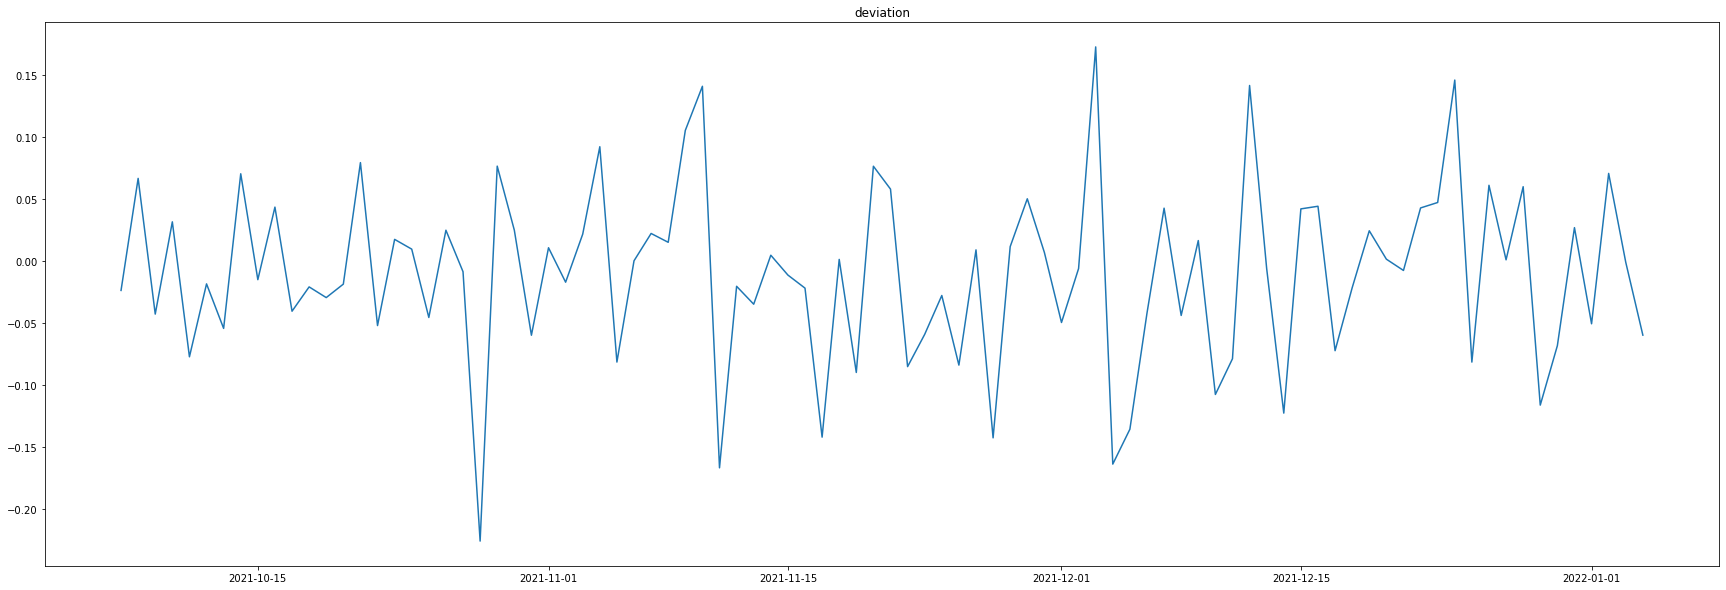

In [135]:
def deviation(df: pd.DataFrame, columns: list, duration: int) -> pd.DataFrame:
    '''
    duration in days
    columns name where the first column name provided will be subtracted by the second column
    '''
    
    new_df = time_prior(df, duration, 'day')
    deviation_data = [new_df[columns[0]][i] - new_df[columns[1]][i] for i in new_df.index]

    return pd.DataFrame({'Date': new_df['Date'], 'Deviation': deviation_data})

df_deviation = deviation(df_cardano, ['Closing Price (USD)', '24h Open (USD)'], 90)
plt.figure(figsize = (30,10))
plt.title('deviation')
plt.grid(False)
plt.plot(df_deviation['Date'], df_deviation['Deviation'])

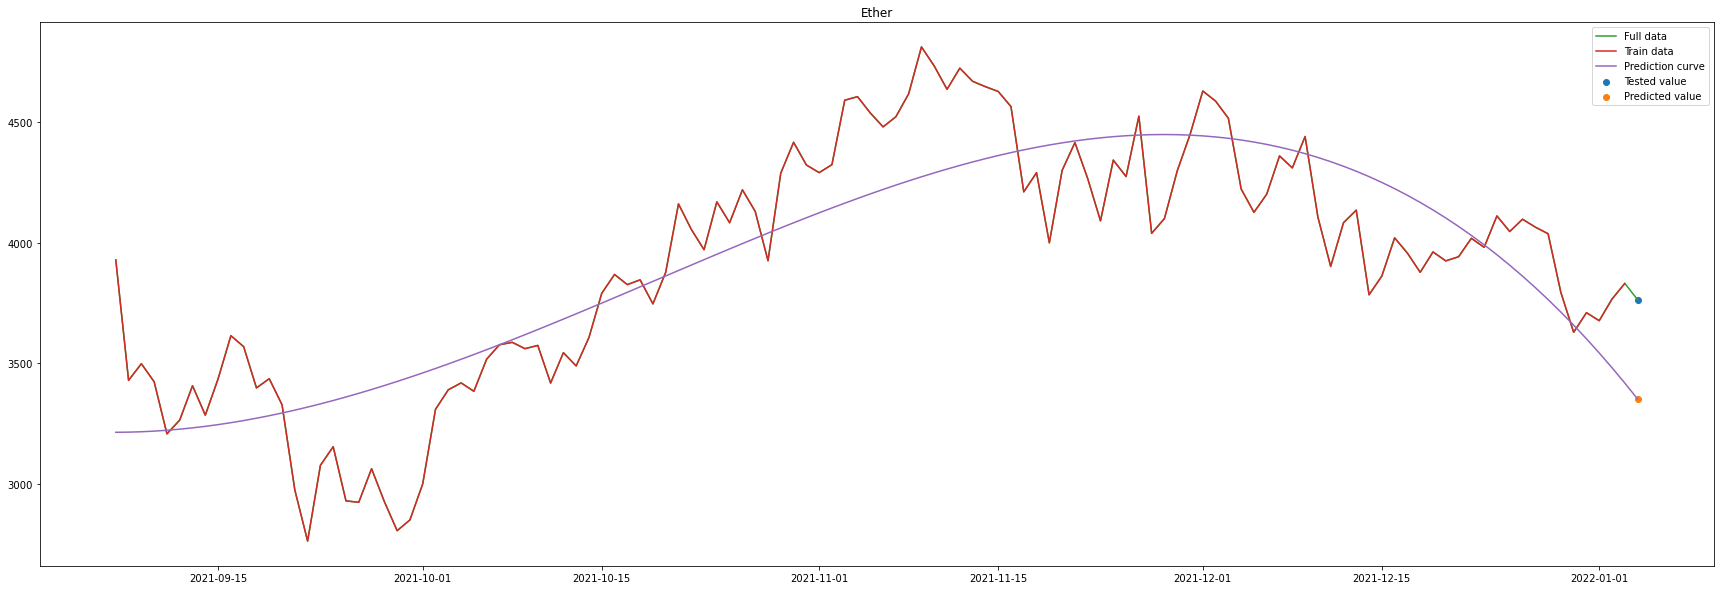

[411.58800813]


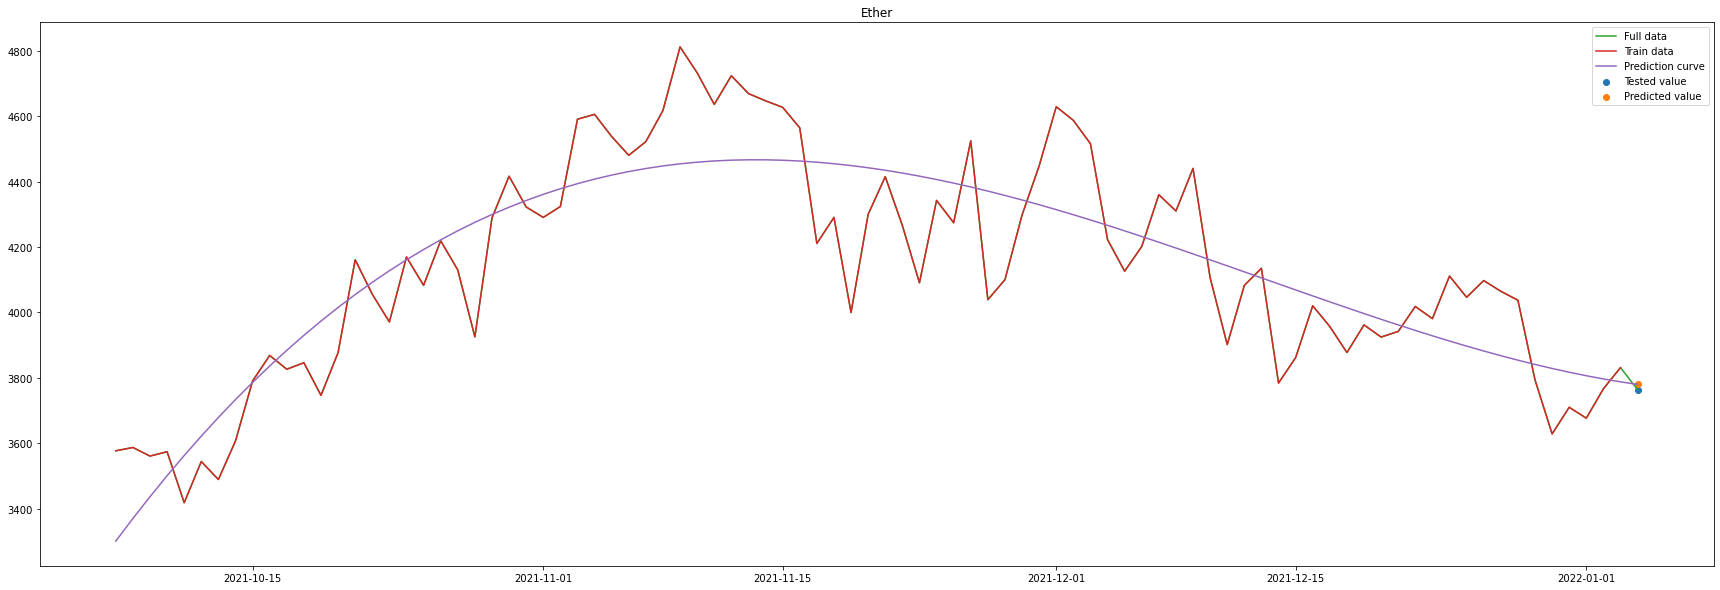

[16.11960751]


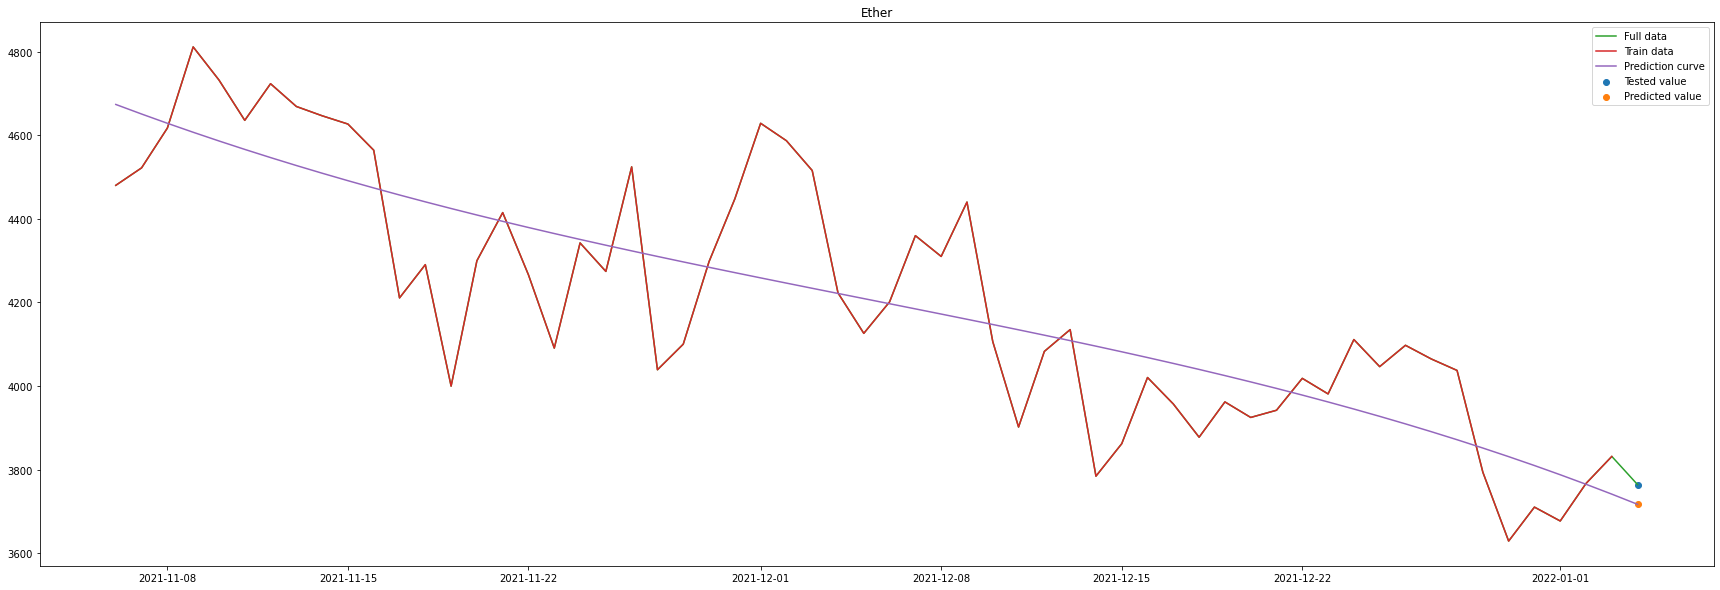

[47.11847022]


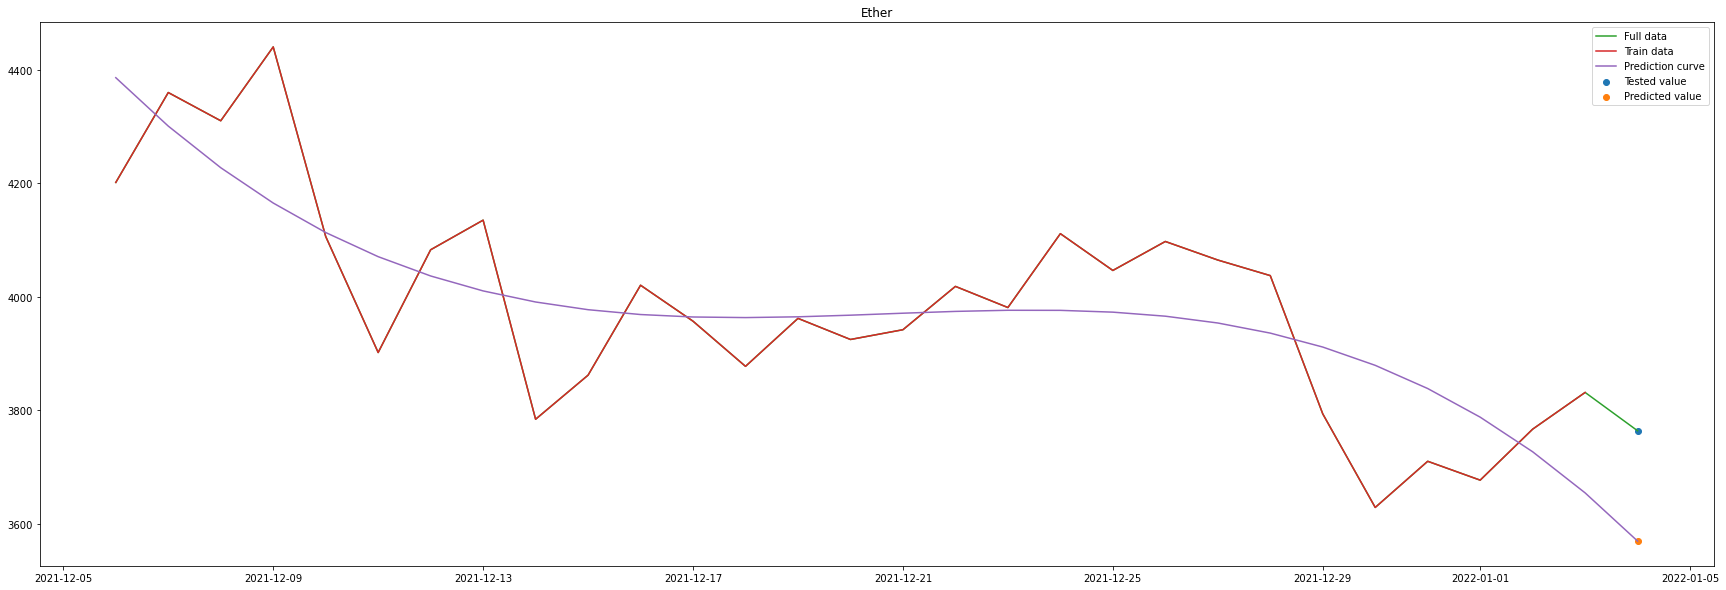

[194.33518505]


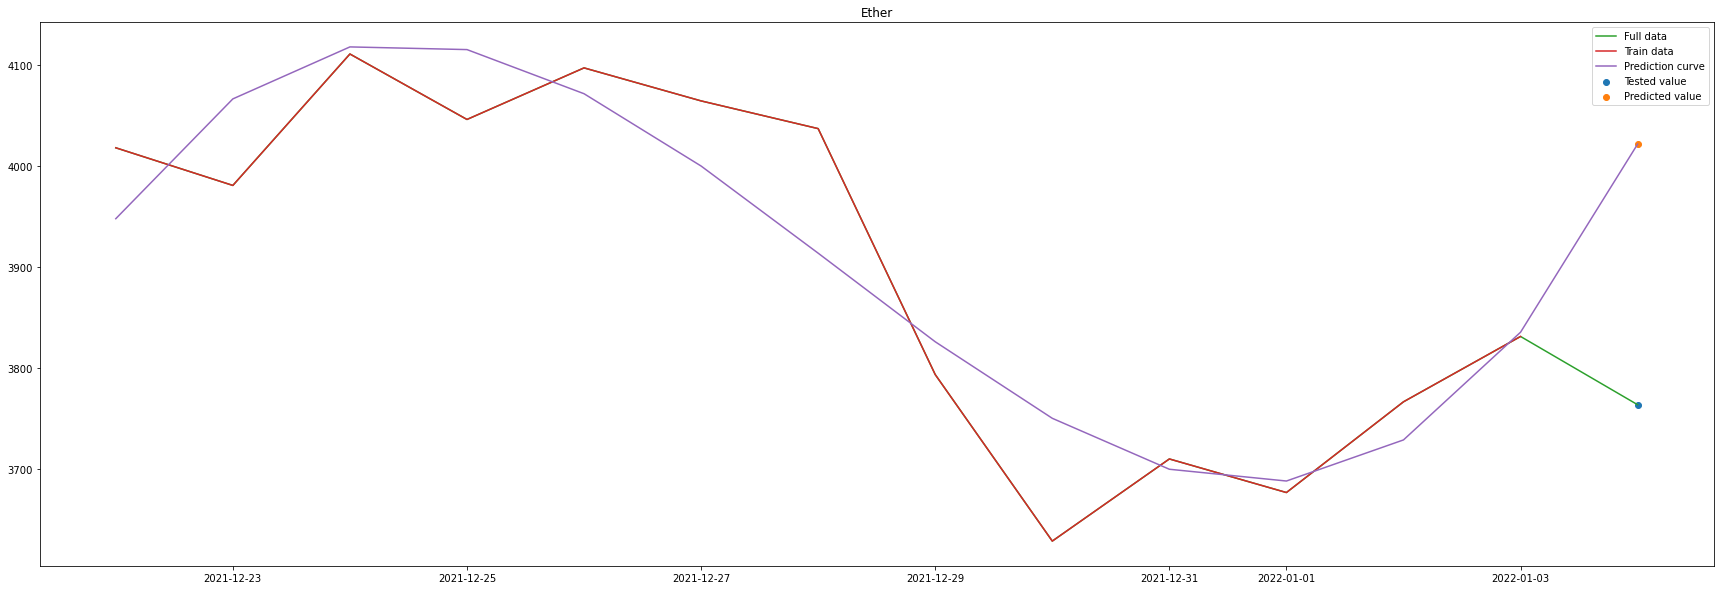

[258.07874471]


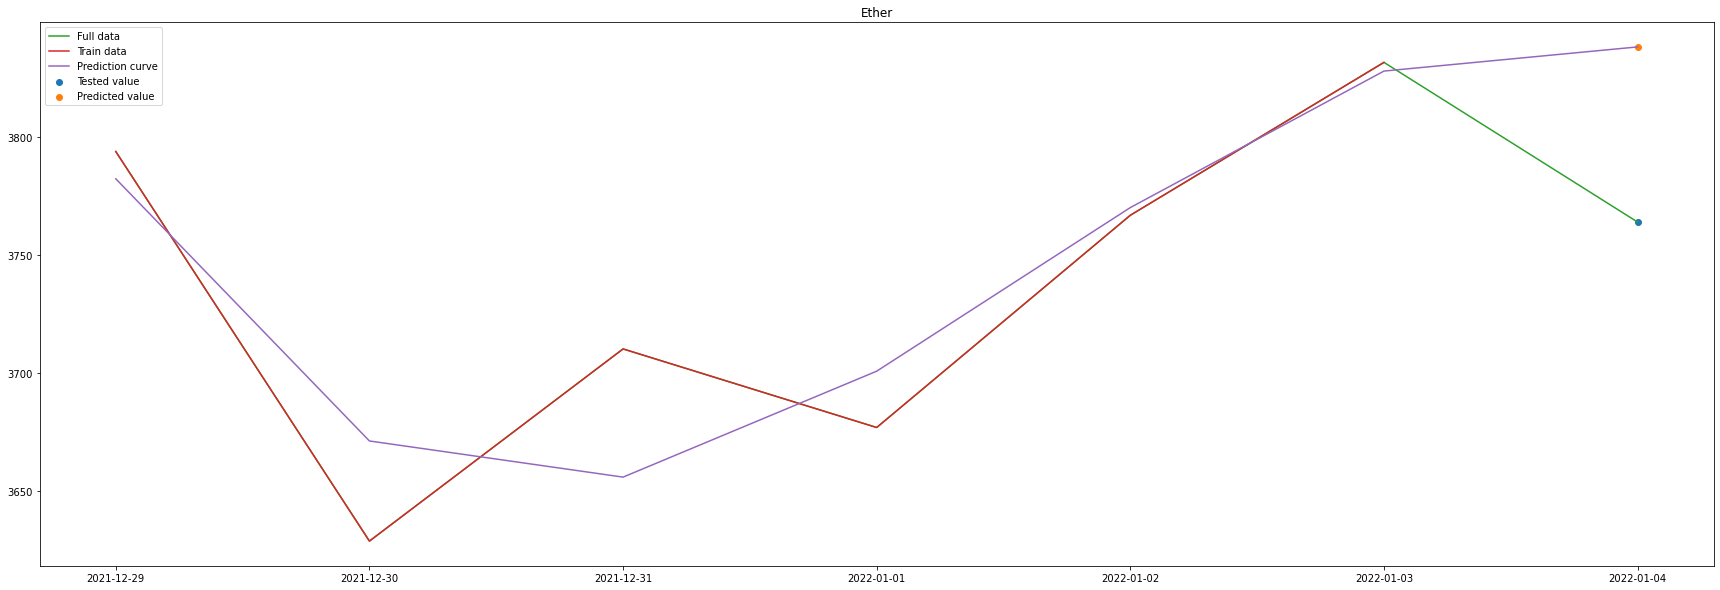

[74.14522677]


In [136]:
print(polynomial_regression_model_predict(df_ethereum, 6, 120, name = 'Ether'))
print(polynomial_regression_model_predict(df_ethereum, 6, 90 , name = 'Ether'))
print(polynomial_regression_model_predict(df_ethereum, 6, 60 , name = 'Ether'))
print(polynomial_regression_model_predict(df_ethereum, 6, 30 , name = 'Ether'))
print(polynomial_regression_model_predict(df_ethereum, 6, 14 , name = 'Ether'))
print(polynomial_regression_model_predict(df_ethereum, 6, 7  , name = 'Ether'))

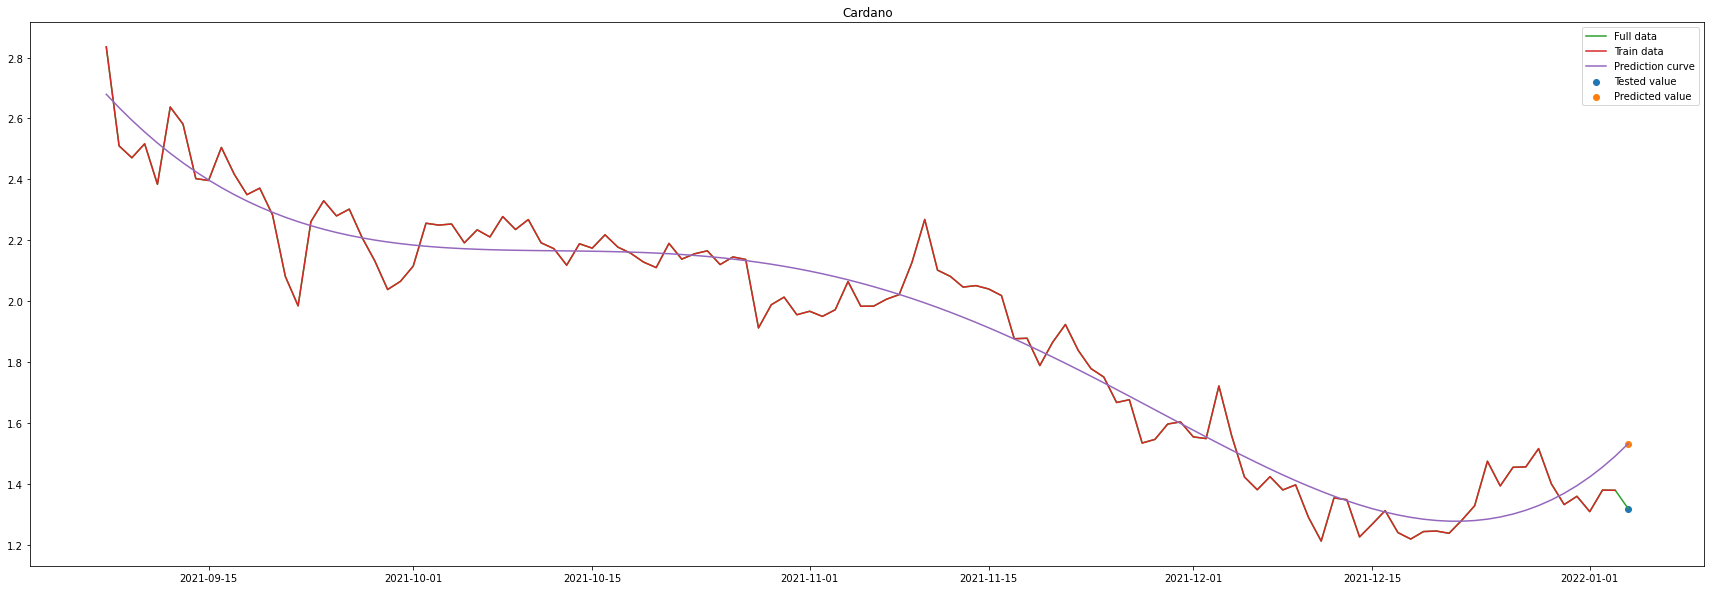

[0.21257897]


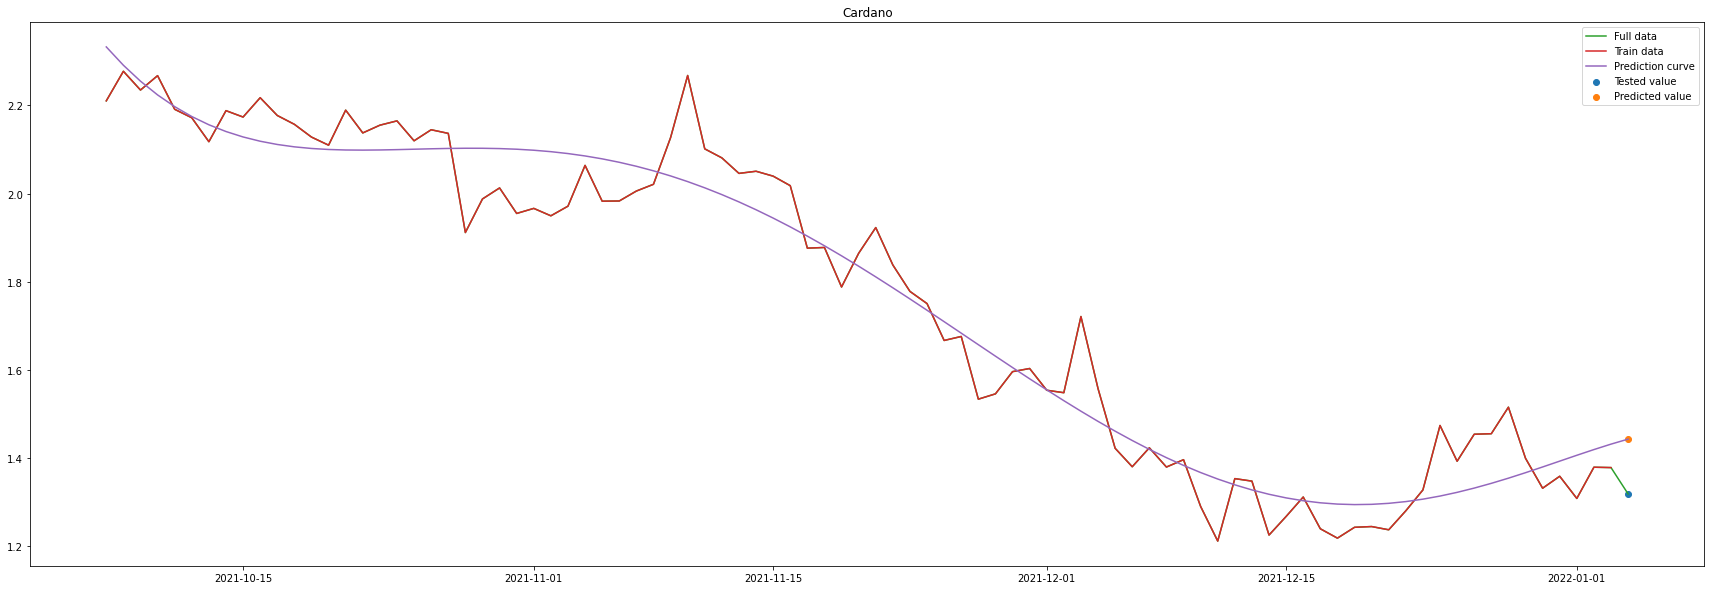

[0.12442055]


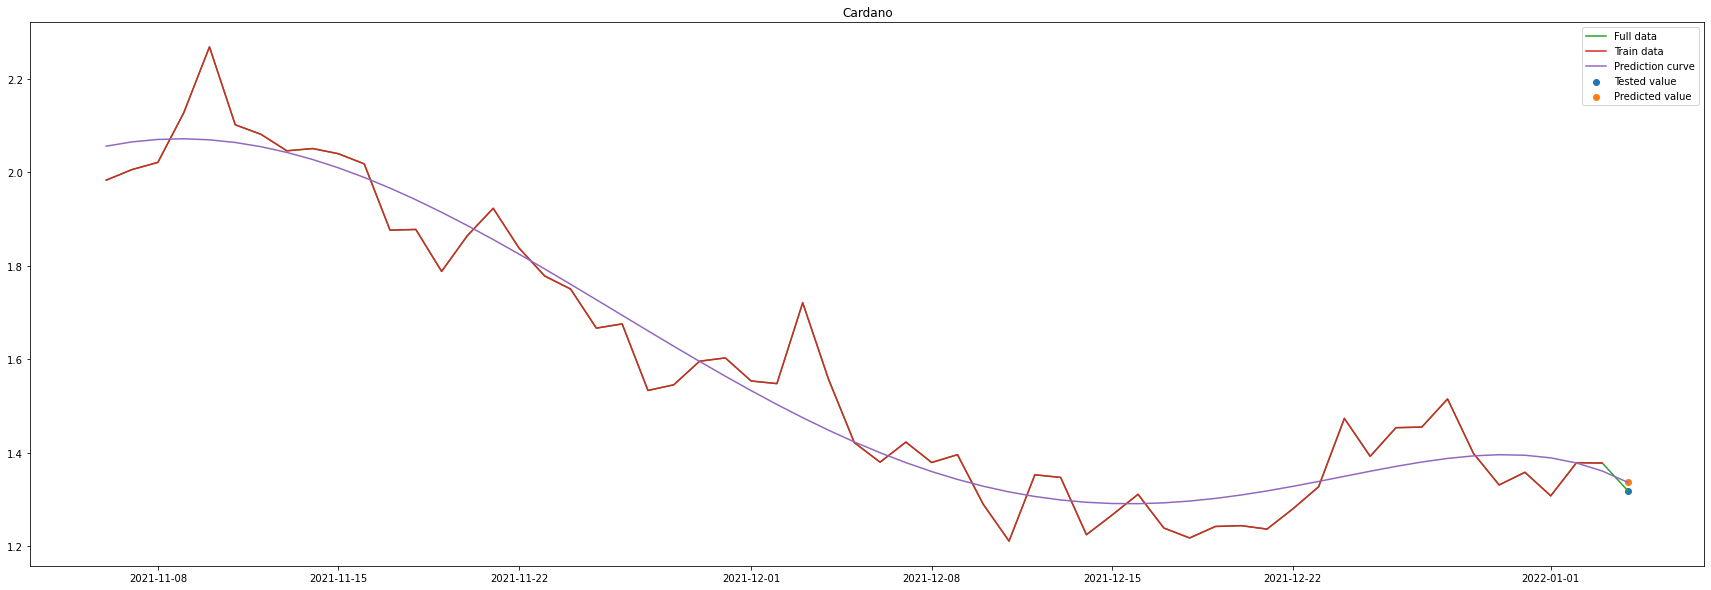

[0.01831936]


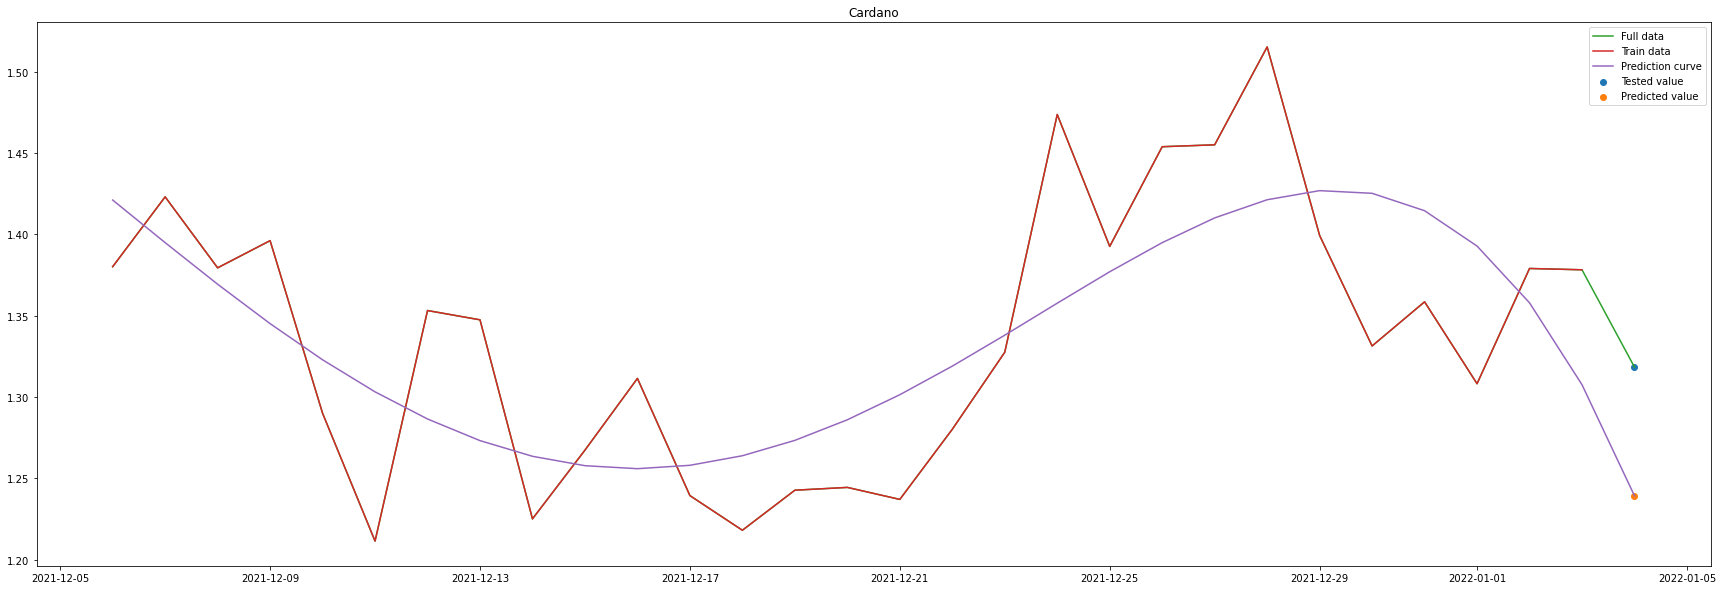

[0.07914851]


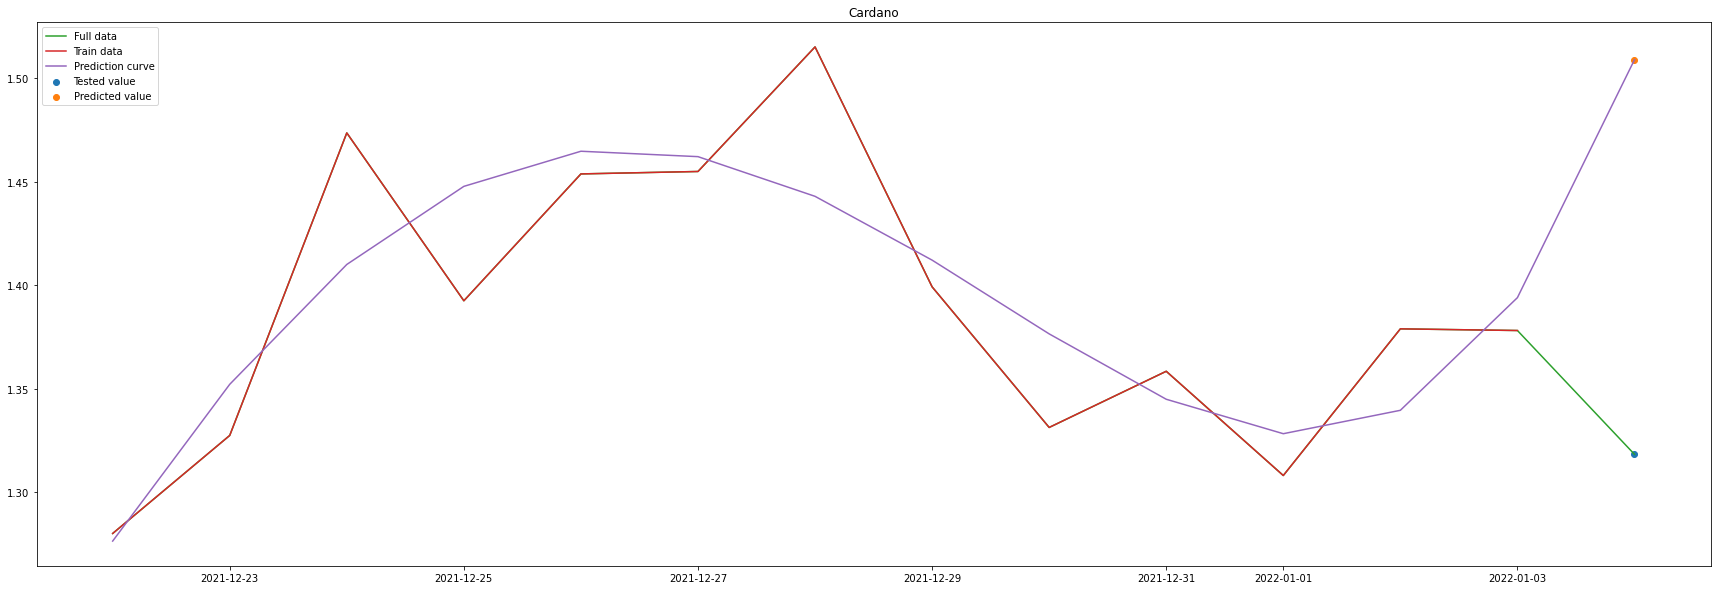

[0.1907]


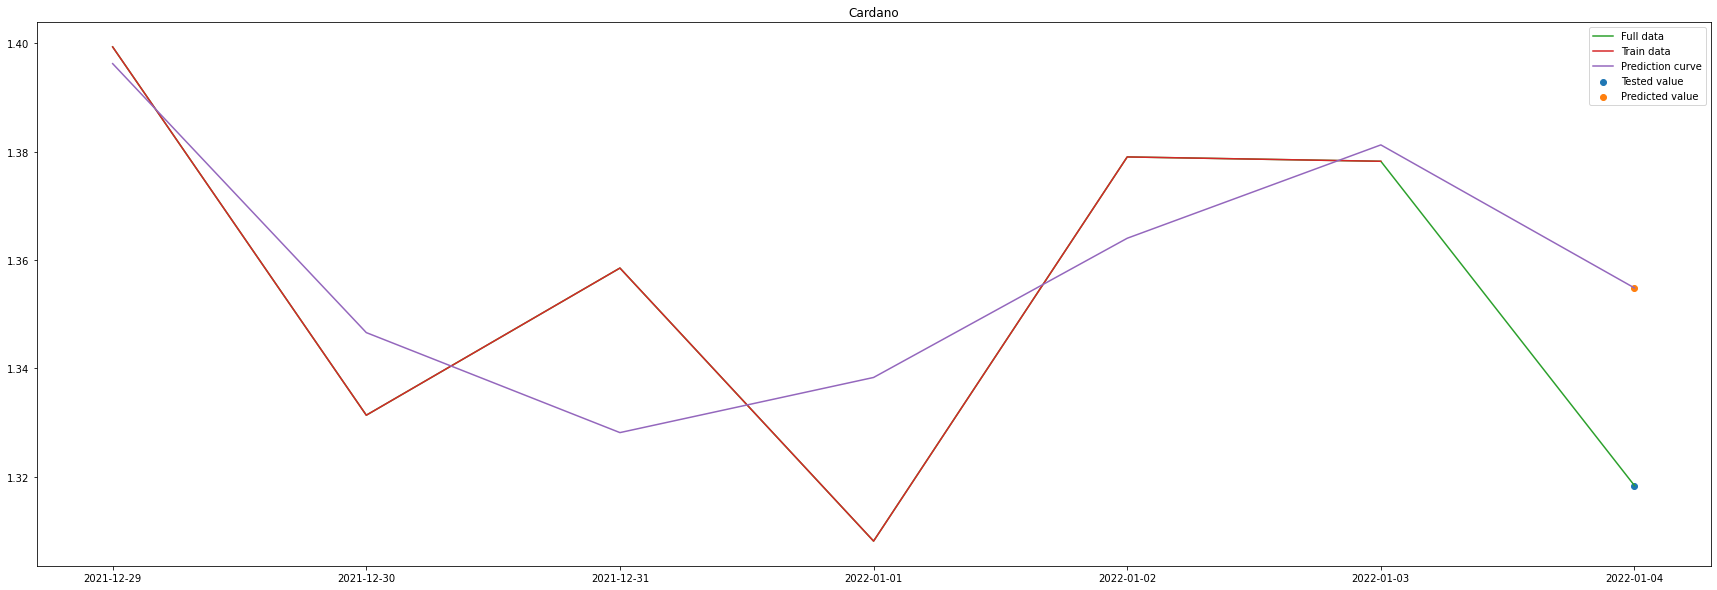

[0.03646294]


In [137]:
print(polynomial_regression_model_predict(df_cardano, 6, 120, name = 'Cardano'))
print(polynomial_regression_model_predict(df_cardano, 6, 90 , name = 'Cardano'))
print(polynomial_regression_model_predict(df_cardano, 6, 60 , name = 'Cardano'))
print(polynomial_regression_model_predict(df_cardano, 6, 30 , name = 'Cardano'))
print(polynomial_regression_model_predict(df_cardano, 6, 14 , name = 'Cardano'))
print(polynomial_regression_model_predict(df_cardano, 6, 7  , name = 'Cardano'))

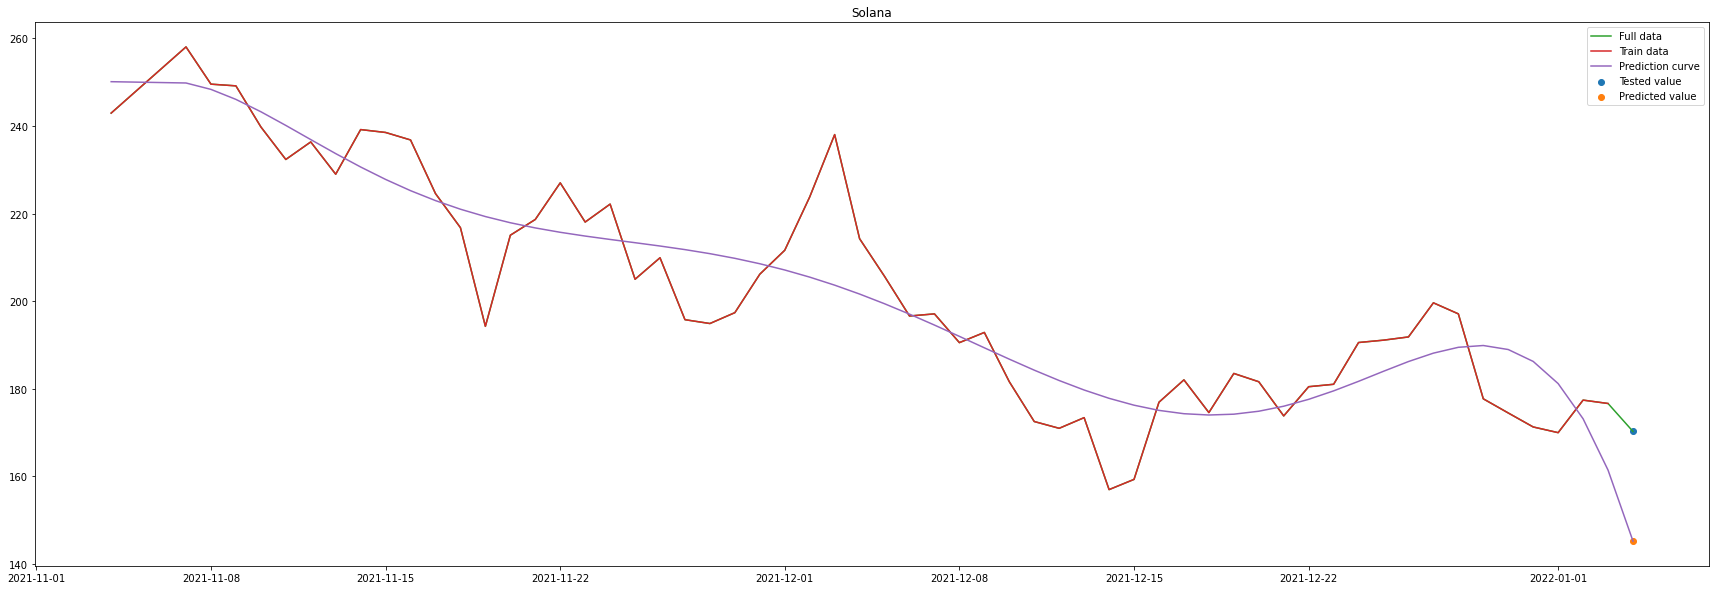

[25.03232907]


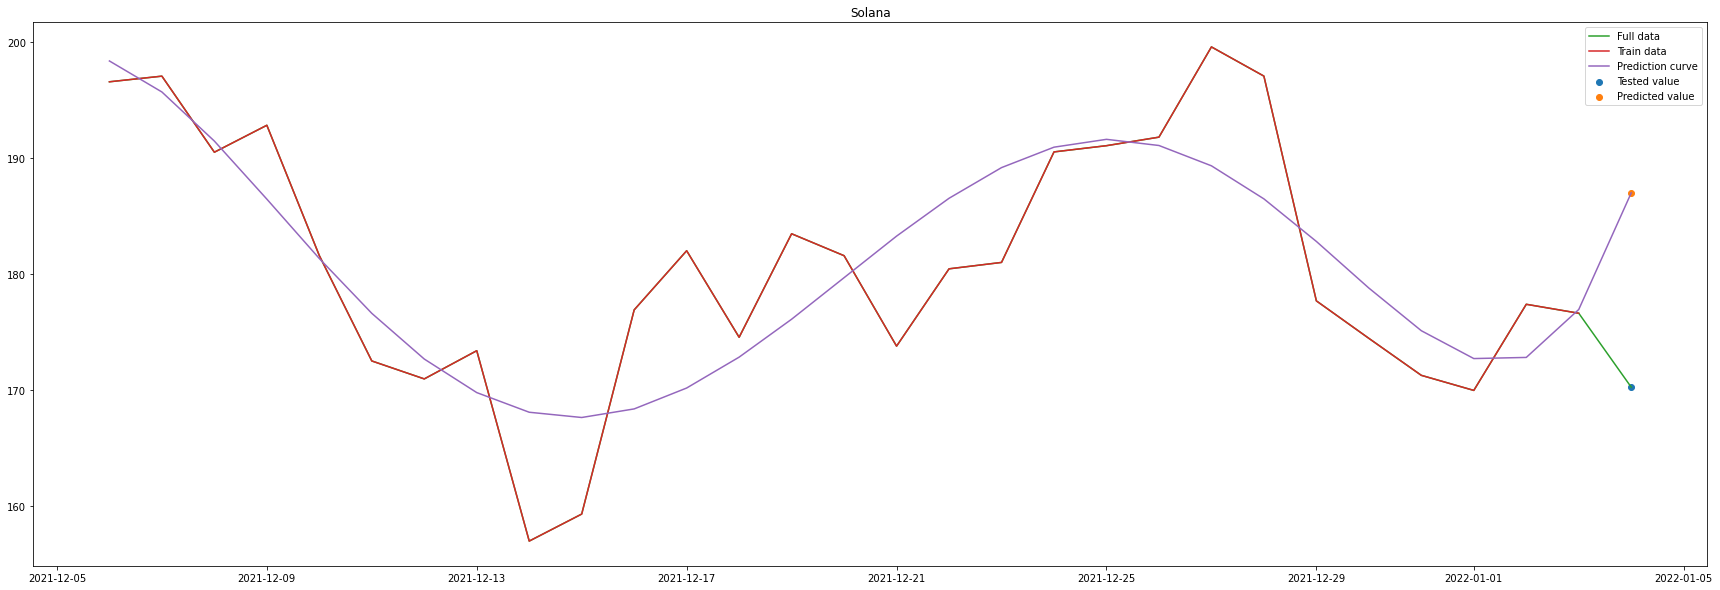

[16.76426153]


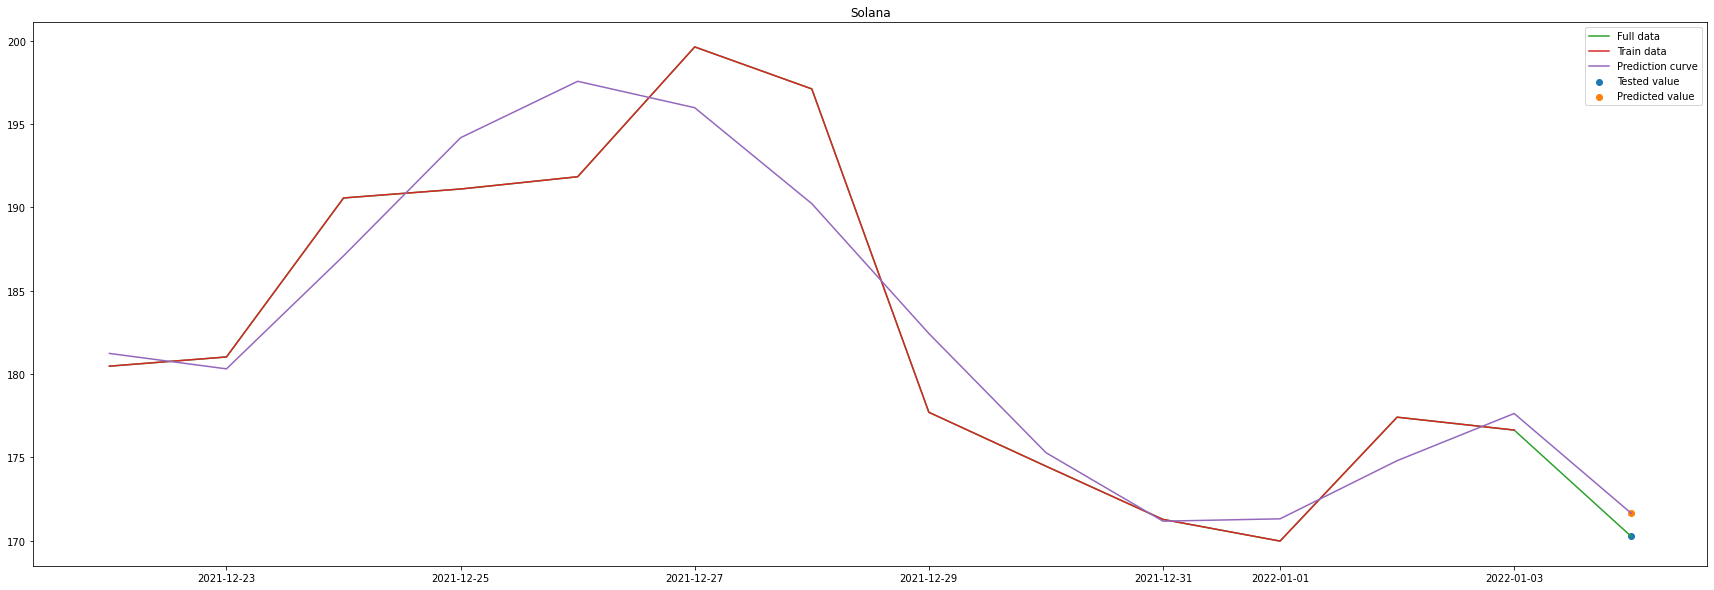

[1.39020414]


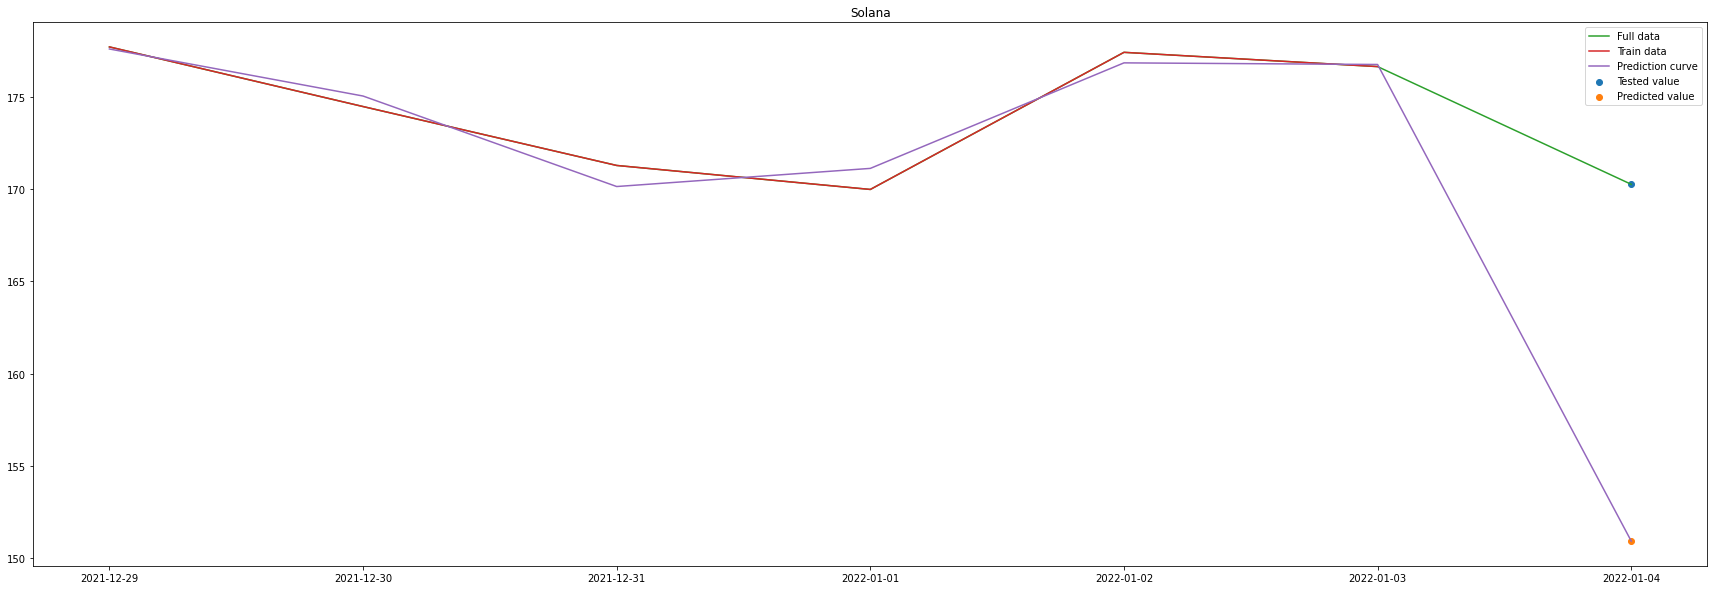

[19.33590605]


In [138]:
print(polynomial_regression_model_predict(df_solana, 6, 60 , name = 'Solana'))
print(polynomial_regression_model_predict(df_solana, 6, 30 , name = 'Solana'))
print(polynomial_regression_model_predict(df_solana, 6, 14 , name = 'Solana'))
print(polynomial_regression_model_predict(df_solana, 4, 7  , name = 'Solana'))